# Skeleton plot that shows the arborization of all 6 clusters by Color
Steps in this file:
- Import skeleton, using 2d skeletons segments (kind of buggy)
- Import partition data for full connectome
- Import synapse location data
- Process dataframes so that synapse location and cluster are on the same dataframe
- Assign colors with a dictionary and then map
- Plot segments and synapses with legend

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bokeh
import bokeh.palettes
from bokeh.plotting import figure, output_notebook, show, output_file
from bokeh.io import export_svg, export_png
from bokeh.models import Legend, LegendItem
import os
from neuprint import Client


auth_token_file = open("/Users/rhessa/flybrain-clustering/flybrain.auth.txt", 'r')
auth_token = next(auth_token_file).strip()
try:
    np_client = Client('neuprint.janelia.org', dataset='hemibrain:v1.2.1', token=auth_token)
except:
    np_client = None

output_notebook()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Loading BokehJS ...

In [2]:
# Create skeleton for later usage (inspired from Prof G.'s notebook ovi_specs_sandbox.ipynb)
# body Ids of oviINs
ovi_r = 423101189
ovi_l = 485934965
ovis = [ovi_r, ovi_l]

# cretae skeleton for both oviINs
skeletons = []

for i in ovis:
    s = np_client.fetch_skeleton(i, format='pandas')
    s['bodyId'] = i
    s['color'] = bokeh.palettes.Greys[3][1]
    skeletons.append(s)

skeletons = pd.concat(skeletons, ignore_index=True)

In [4]:
# Join parent nodes
segments = skeletons.merge(skeletons, left_on=['bodyId', 'link'], right_on=['bodyId', 'rowId'], suffixes=['_child', '_parent'])

In [13]:
# import full connectome data and location data
ovi_node_df  = pd.read_csv('/Users/rhessa/flybrain-clustering/oviIN_combined/preprocessed_inputs-v1.2.1/preprocessed_nodes.csv')

# Import synapse location data for pre-synaptic sites
ovi_pre_syns = pd.read_csv('/Users/rhessa/flybrain-clustering/ovi_pre_syns.csv', index_col=0)

In [14]:
ovi_pre_syns

,bodyId_pre,bodyId_post,roi_pre,roi_post,x_pre,y_pre,z_pre,x_post,y_post,z_post,confidence_pre,confidence_post,type_pre,type_post
0,989228019,423101189,CRE(R),CRE(R),22857,34611,17485,22825,34624,17464,0.998,0.633171,FB5V,NaN
1,988909130,423101189,CRE(R),CRE(R),19523,31096,21707,19509,31112,21693,0.969,0.528840,FB5V,NaN
2,988567837,423101189,LAL(R),LAL(R),23100,27659,23824,23074,27659,23801,0.970,0.459446,FB4G,NaN
3,987842109,423101189,SMP(R),SMP(R),19041,33090,14598,19047,33072,14598,0.973,0.974019,NaN,NaN
4,987273073,423101189,CRE(R),CRE(R),19347,27826,15348,19351,27806,15376,0.943,0.595921,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21619,1006928515,423101189,IB,IB,22664,14840,19749,22651,14823,19757,0.994,0.865103,CL300,NaN
21620,1005952640,423101189,IB,IB,21998,15625,18990,22007,15603,18991,0.996,0.929040,IB058,NaN
21621,1005952640,423101189,IB,IB,22998,15275,23049,23014,15272,23060,0.835,0.780000,IB058,NaN
21622,1005952640,423101189,IB,IB,23034,15380,23131,23048,15364,23146,0.986,0.905853,IB058,NaN


In [15]:
# edit dataframes for easy merging
ovi_clusters = ovi_node_df[['id', '0.0']].copy()
ovi_locs = ovi_pre_syns[['bodyId_pre', 'x_pre', 'y_pre', 'z_pre']].copy()

# merge synapse data onto cluster data
ovi_plotting = ovi_clusters.merge(ovi_locs, left_on='id', right_on='bodyId_pre').drop(columns='bodyId_pre')
ovi_plotting

,id,0.0,x_pre,y_pre,z_pre
0,1003215282,1,24301,16887,21862
1,1005952640,2,21998,15625,18990
2,1005952640,2,22998,15275,23049
3,1005952640,2,23034,15380,23131
4,1006928515,1,22664,14840,19749
...,...,...,...,...,...
21619,987273073,4,19347,27826,15348
21620,987842109,4,19041,33090,14598
21621,988567837,2,23100,27659,23824
21622,988909130,2,19523,31096,21707


In [20]:
# Create color dictionary where each number in column 0.0 is assigned a color
color_dict = {1: 'red', 2: 'blue', 3: 'green', 4: 'yellow', 5: 'pink', 6: 'orange'}

# Merge color dictionary onto dataframe
ovi_plotting['color'] = ovi_plotting['0.0'].map(color_dict)
ovi_plotting

,id,0.0,x_pre,y_pre,z_pre,color
0,1003215282,1,24301,16887,21862,red
1,1005952640,2,21998,15625,18990,blue
2,1005952640,2,22998,15275,23049,blue
3,1005952640,2,23034,15380,23131,blue
4,1006928515,1,22664,14840,19749,red
...,...,...,...,...,...,...
21619,987273073,4,19347,27826,15348,yellow
21620,987842109,4,19041,33090,14598,yellow
21621,988567837,2,23100,27659,23824,blue
21622,988909130,2,19523,31096,21707,blue


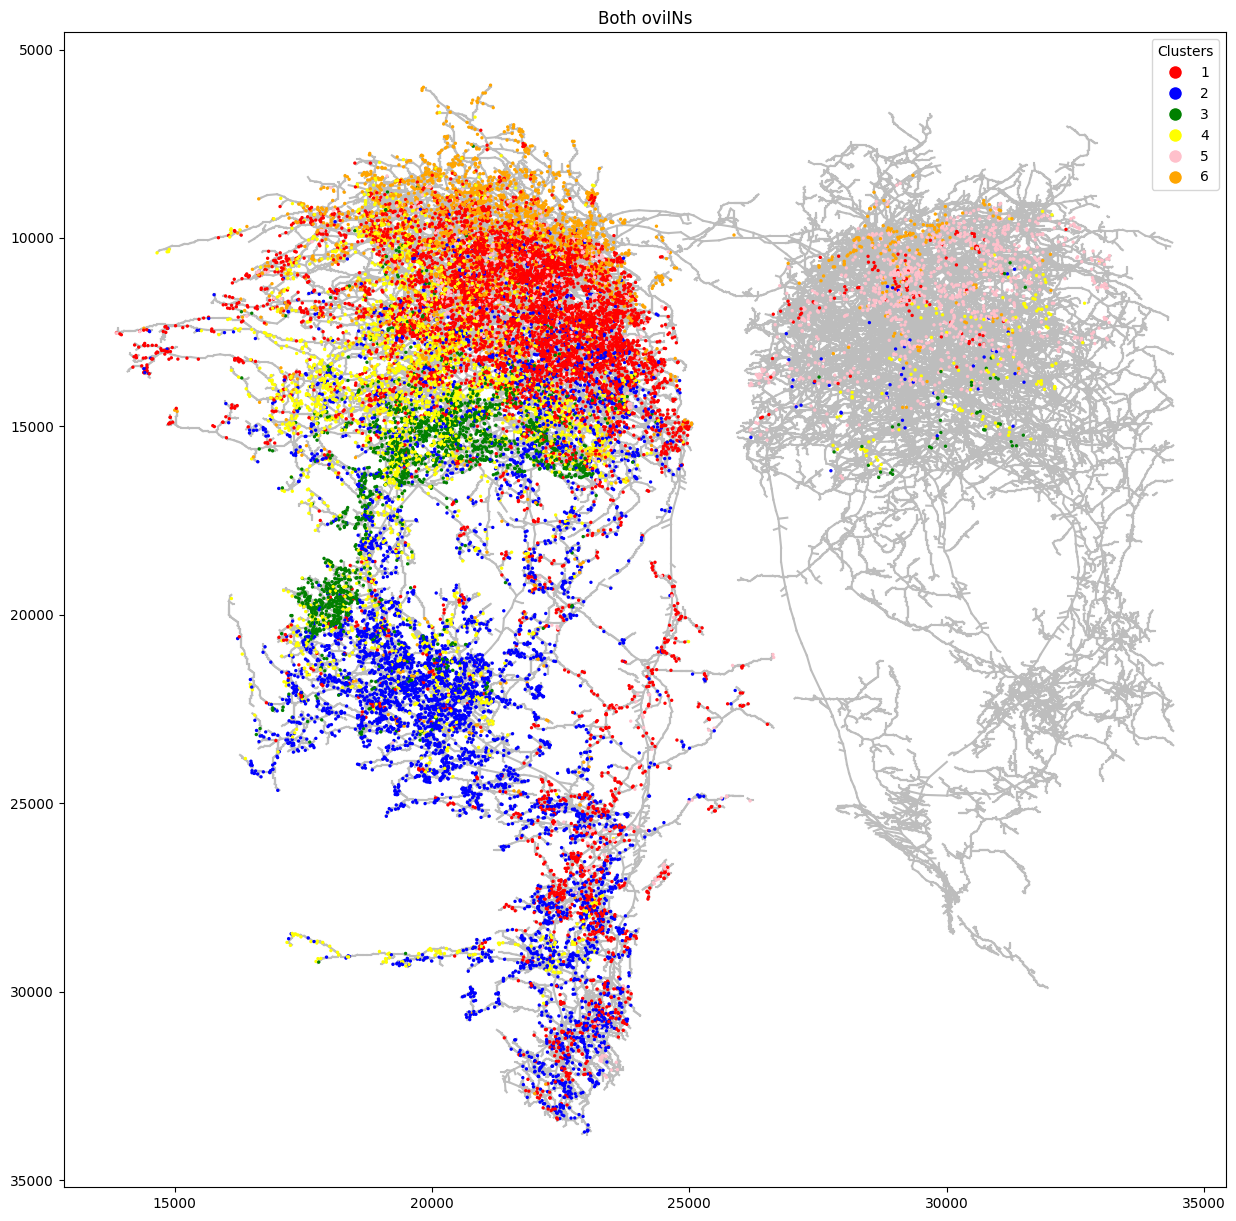

In [21]:
# Plot the skeleton and clusters with labels
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title('Both oviINs')
ax.invert_yaxis()  # Flip the y-axis

# Plot the skeleton (2D)
for index, row in segments.iterrows():
    ax.plot([row['x_child'], row['x_parent']], [row['z_child'], row['z_parent']], color=row['color_child'], zorder=1)

# plot clusters with legend of clusters corresponding to colors
ax.scatter(ovi_plotting['x_pre'], ovi_plotting['z_pre'], c=ovi_plotting['color'], s=2, zorder=2)
ax.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='1'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='2'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='3'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='4'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='pink', markersize=10, label='5'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='6')], title='Clusters')
